<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Таблица имеет всего 2 столбца:
- **datetime** - *дата и время*
- **num_orders** - *количество заказов*

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

rs = 42 # random_state

## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head(3) #Посмотрим первые 3 значения

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%dT%H:%M:%S")
# переведем столбец datetime в нужный формат

In [6]:
df.index = df['datetime'] #Переведем дату в индекс
df = df.drop('datetime', axis = 1)

In [7]:
df.index.is_monotonic #проверим, отсортированы ли индексы

True

In [8]:
df = df.resample('1H').sum() # ресемплирование по одному часу

## Анализ

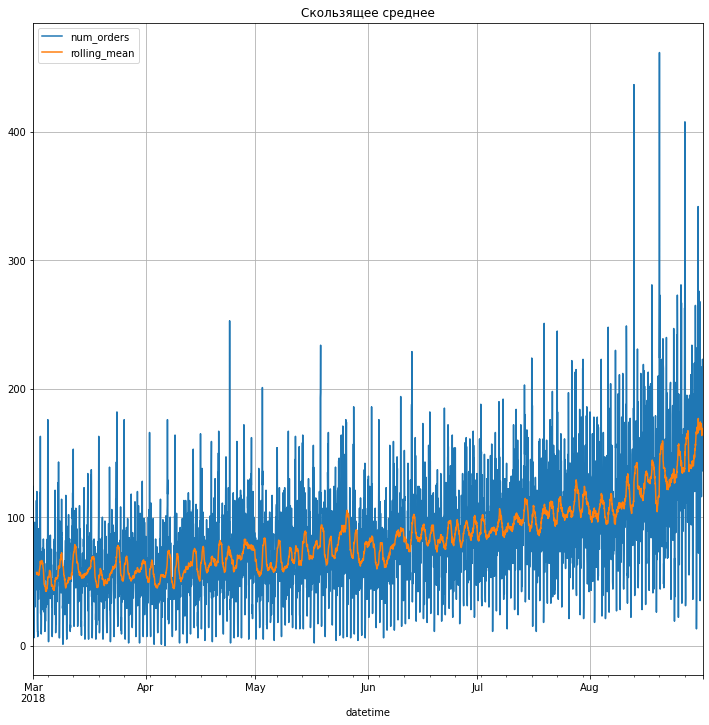

In [9]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot(figsize=(12, 12))
plt.title('Скользящее среднее')
plt.grid()
plt.legend()
plt.show
df = df.drop('rolling_mean', axis = 1)

**На графике мы видим число заказов по часам и скользящее среднее. По скользящему среднему мы можем наблюдать постоянные колебания количества заказов и постепенный их рост**

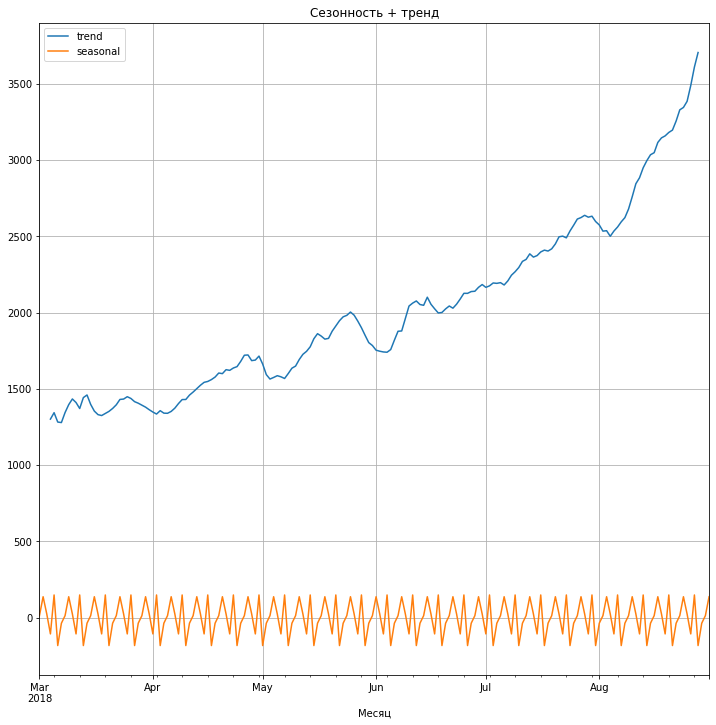

In [10]:
decomposed = seasonal_decompose(df.resample('D').sum())
decomposed.trend.plot(figsize=(12, 12))
decomposed.seasonal.plot()
# decomposed.resid.plot()
plt.legend()
plt.grid()
plt.title('Сезонность + тренд')
plt.xlabel('Месяц')
plt.show()

**По графику можно сказать, что со временем общее число заказов растет, причем в начале почти каждого месяца немного снижается. Сезонность колеблется по дням, посмотрим ее по дням недели:**

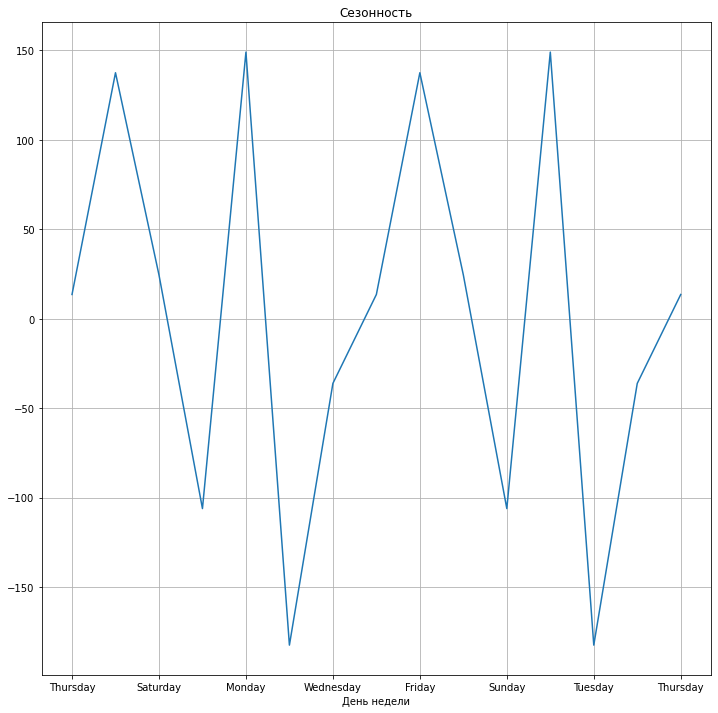

In [11]:
fff = decomposed.seasonal['2018-03-01':'2018-03-15']
fff.index = fff.index.day_name()
fff.plot(figsize=(12, 12))
plt.grid()
plt.title('Сезонность')
plt.xlabel('День недели')
plt.show()

**По графику можно сказать, что чащее всего такси заказывают в понедельник и пятницу, а на выходных и в остальные будни - гораздо меньше среднего**

## Обучение

**Добавим в данные:**

- календарные признаки(год, месяц, день, день недели)
- «Отстающие значения»(Предыдущие значения временного ряда)
- Скользящее среднее

**Разделим на фичи и таргеты, а так же на тренировочную и тестовую выборки**

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df,24,24)

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state = rs)
train = train.dropna()
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

----
**Возьмем 3 модели: Линейную регрессию, cat boost и случайный лес с подбором параметров через random search. Сначала посмотрим метрику RMSE, полученную кросс-валидацие, а затем на тестовой выборке**

**LinearRegression**

In [13]:
model_lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
RMSE_lr  = np.mean(abs(cross_val_score(model_lr, train_features, train_target, cv=tscv, scoring = 'neg_root_mean_squared_error')))

print('средний RMSE методом cross_val_score для linear regression', RMSE_lr)

средний RMSE методом cross_val_score для linear regression 27.202439726131537


**CatBoostRegressor**

In [14]:
model_cat = CatBoostRegressor(iterations=1000, verbose=200, early_stopping_rounds=100, 
                              random_state = rs)
RMSE_cat  = np.mean(abs(cross_val_score(model_cat, train_features, train_target, cv=tscv, scoring = 'neg_root_mean_squared_error')))
print('средний RMSE методом cross_val_score для catboost', RMSE_cat)

Learning rate set to 0.038341
0:	learn: 29.1647454	total: 52ms	remaining: 52s
200:	learn: 12.1764464	total: 730ms	remaining: 2.9s
400:	learn: 8.1045398	total: 1.41s	remaining: 2.1s
600:	learn: 5.3452749	total: 2.09s	remaining: 1.39s
800:	learn: 3.6580081	total: 2.78s	remaining: 691ms
999:	learn: 2.5269540	total: 3.51s	remaining: 0us
Learning rate set to 0.042769
0:	learn: 29.7902268	total: 5.96ms	remaining: 5.95s
200:	learn: 14.3559256	total: 778ms	remaining: 3.09s
400:	learn: 10.7617123	total: 1.55s	remaining: 2.32s
600:	learn: 8.4247998	total: 2.31s	remaining: 1.54s
800:	learn: 6.6551623	total: 3.08s	remaining: 766ms
999:	learn: 5.3111967	total: 3.9s	remaining: 0us
Learning rate set to 0.045595
0:	learn: 31.3958098	total: 6.66ms	remaining: 6.65s
200:	learn: 15.4629382	total: 900ms	remaining: 3.58s
400:	learn: 12.3911126	total: 1.78s	remaining: 2.66s
600:	learn: 10.0976726	total: 2.67s	remaining: 1.77s
800:	learn: 8.3370608	total: 3.57s	remaining: 886ms
999:	learn: 7.0397312	total: 4.

----
**RandomForestRegressor через RandomizedSearchCV**

In [15]:
model_rfr = RandomForestRegressor(random_state = rs)
n_estimators = range(100, 251, 50)
max_depth = range(6, 34, 3)
random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rfr_random = RandomizedSearchCV(estimator = model_rfr, param_distributions = random_grid, cv = tscv,
                          random_state=rs, scoring = 'neg_root_mean_squared_error')
rfr_random.fit(train_features, train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': range(6, 34, 3),
                                        'n_estimators': range(100, 251, 50)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [16]:
print('Лучшие параметры', rfr_random.best_params_)
print('Лучший результат', abs(rfr_random.best_score_))

Лучшие параметры {'n_estimators': 250, 'max_depth': 33}
Лучший результат 25.766017721442996


In [17]:
rmse = pd.DataFrame({'RMSE cross-val:': [RMSE_lr, RMSE_cat,
                                     abs(rfr_random.best_score_)]}).T
rmse.columns = ['LinearRegression','CatBoostRegressor','RandomForestRegressor']
rmse

,LinearRegression,CatBoostRegressor,RandomForestRegressor
RMSE cross-val:,27.20244,24.826561,25.766018


**Все модели показали отличный результат на кросс-валидации. Самый низкий RMSE у CatBoostRegressor. Проведем тесты всех 3х моделей**

## Тестирование

In [18]:
%%time
#LinearRegression
model_lr.fit(train_features, train_target)
test_lr = mean_squared_error(model_lr.predict(test_features), test_target, squared = False)
test_lr

CPU times: user 23.2 ms, sys: 12 ms, total: 35.2 ms
Wall time: 9.2 ms


44.979039433306596

In [19]:
%%time
#CatBoostRegressor
model_cat.fit(train_features, train_target)
test_cat = mean_squared_error(model_cat.predict(test_features), test_target, squared = False)
test_cat

Learning rate set to 0.050868
0:	learn: 37.8350515	total: 7.5ms	remaining: 7.49s
200:	learn: 20.4346335	total: 1.23s	remaining: 4.89s
400:	learn: 16.8208048	total: 2.61s	remaining: 3.9s
600:	learn: 14.4472449	total: 3.9s	remaining: 2.59s
800:	learn: 12.6682516	total: 5.12s	remaining: 1.27s
999:	learn: 11.2850328	total: 6.38s	remaining: 0us
CPU times: user 6.46 s, sys: 105 ms, total: 6.57 s
Wall time: 7.67 s


41.371590431199905

In [20]:
%time
#RandomForestRegressor
test_rfr = mean_squared_error(rfr_random.predict(test_features), test_target, squared = False)
test_rfr

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


43.52867175049098

In [21]:
test_rmse = pd.DataFrame({'RMSE test:': [test_lr, test_cat,test_rfr]}).T
test_rmse.columns = ['LinearRegression','CatBoostRegressor','RandomForestRegressor']
test_rmse

,LinearRegression,CatBoostRegressor,RandomForestRegressor
RMSE test:,44.979039,41.37159,43.528672


**Исходя из результатов проверки на тестовой выборке: все модели так же имют требуемый по качеству показатель RMSE, но уже на порядок выше. Лучший результат, как кросс-валидацией так и на тесте - у CatBoostRegressor. Рекомендую эту модель**